In [3]:
# --- CELL 1: IMPORT THƯ VIỆN CHO RANDOM FOREST VÀ CÁC TÁC VỤ LIÊN QUAN ---

# Thư viện cơ bản cho xử lý dữ liệu và tính toán
import pandas as pd
import numpy as np

# Thư viện cho trực quan hóa
import matplotlib.pyplot as plt
import seaborn as sns # Hữu ích cho một số biểu đồ EDA và phân tích phần dư

# Thư viện Scikit-learn
from sklearn.ensemble import RandomForestRegressor # Mô hình Random Forest
from sklearn.model_selection import train_test_split # Dùng để chia train/test (cần cẩn thận với chuỗi thời gian)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Các độ đo đánh giá
import statsmodels.api as sm
# (Tùy chọn) Statsmodels cho phân tích phần dư nâng cao (nếu cần)
# import statsmodels.api as sm # Cho Q-Q plot
# from statsmodels.graphics.tsaplots import plot_acf # Cho ACF của phần dư
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler # Để chuẩn hóa dữ liệu
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

# Cài đặt cho Matplotlib để hiển thị biểu đồ ngay trong notebook
%matplotlib inline

# Cài đặt cho Pandas để hiển thị số float (tùy chọn)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_columns', 50)

print("--- Cell 1: Import Thư viện cho Random Forest Hoàn Tất ---")

--- Cell 1: Import Thư viện cho Random Forest Hoàn Tất ---


In [4]:
# --- PHẦN 1: ĐỌC VÀ TIỀN XỬ LÝ DỮ LIỆU CHUNG ---

print("--- BẮT ĐẦU QUÁ TRÌNH XỬ LÝ DỮ LIỆU ---")

# 1.1. Đọc dữ liệu từ file CSV
file_path = 'World GDP Dataset.csv'
try:
    df_raw_initial = pd.read_csv(file_path)
    df_raw = pd.read_csv(file_path, na_values=['0', 0.0])
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file '{file_path}'. Vui lòng kiểm tra lại đường dẫn.")
    raise
except Exception as e:
    print(f"Lỗi khi đọc file CSV: {e}")
    raise
print("Đọc dữ liệu thô thành công.")

print("\n--- THỐNG KÊ DỮ LIỆU THÔ BAN ĐẦU (df_raw_initial - TRƯỚC KHI XỬ LÝ SÂU) ---")
rows_raw_initial, cols_raw_initial = df_raw_initial.shape
elements_raw_initial = df_raw_initial.size
print(f"Kích thước: {rows_raw_initial} hàng × {cols_raw_initial} cột ({elements_raw_initial} phần tử)")
print("Hiển thị tóm tắt dữ liệu thô ban đầu:")
# Pandas sẽ tự động tóm tắt nếu số hàng > pd.options.display.max_rows (thường là 60)
# Nếu muốn luôn thấy kiểu tóm tắt ngay cả với df nhỏ hơn, bạn cần thủ thuật hơn
# hoặc chấp nhận hiển thị toàn bộ nếu nó nhỏ.
# Với df_raw_initial có 230 hàng, nó sẽ tự tóm tắt.
if 'df_raw_initial' in locals():
    with pd.option_context('display.show_dimensions', True): # Hiển thị kích thước ở cuối
        display(df_raw_initial)
else:
    print("df_raw_initial chưa được tạo.")


# 1.2. Làm sạch cơ bản (áp dụng cho df_raw)
df_raw.dropna(how='all', inplace=True)
rows_before_copyright_removal = len(df_raw)
df_raw = df_raw[~df_raw.iloc[:, 0].astype(str).str.contains("©IMF", na=False)]
rows_after_copyright_removal = len(df_raw)
print(f"\nLàm sạch cơ bản: Loại bỏ {rows_before_copyright_removal - rows_after_copyright_removal} dòng copyright/footer.")

country_col_original_name = df_raw.columns[0]
df_raw.rename(columns={country_col_original_name: 'Country Name'}, inplace=True)
print("Đổi tên cột quốc gia hoàn tất.")

print("\n--- THỐNG KÊ DỮ LIỆU SAU LÀM SẠCH CƠ BẢN (df_raw - TRƯỚC KHI MELT) ---")
rows_raw_cleaned, cols_raw_cleaned = df_raw.shape
elements_raw_cleaned = df_raw.size
print(f"Kích thước: {rows_raw_cleaned} hàng × {cols_raw_cleaned} cột ({elements_raw_cleaned} phần tử)")
print("Hiển thị tóm tắt dữ liệu sau làm sạch cơ bản:")
if 'df_raw' in locals():
    with pd.option_context('display.show_dimensions', True):
        display(df_raw) # df_raw có 196 hàng, cũng sẽ tự tóm tắt
else:
    print("df_raw (đã làm sạch) chưa được tạo.")


# 1.3. Chuyển từ định dạng wide sang long
try:
    df_long = pd.melt(df_raw,
                      id_vars=['Country Name'],
                      var_name='Year',
                      value_name='GDP')
except KeyError as e:
    print(f"Lỗi khi chuyển đổi wide sang long: Cột 'Country Name' hoặc các cột năm không đúng. {e}")
    raise
print("\nChuyển đổi dữ liệu từ wide sang long thành công.")
print("--- THỐNG KÊ DỮ LIỆU SAU KHI MELT (df_long - TRƯỚC KHI CHUYỂN KIỂU VÀ DROPNA) ---")
rows_after_melt, cols_after_melt = df_long.shape
elements_after_melt = df_long.size
print(f"Kích thước: {rows_after_melt} hàng × {cols_after_melt} cột ({elements_after_melt} phần tử)")
print("Hiển thị tóm tắt dữ liệu sau khi melt:")
if 'df_long' in locals():
    with pd.option_context('display.show_dimensions', True):
        # df_long có 8624 hàng, chắc chắn sẽ được Pandas tóm tắt
        display(df_long)
else:
    print("df_long (sau melt) chưa được tạo.")


# 1.4. Chuyển đổi kiểu dữ liệu
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')
if df_long['GDP'].dtype == 'object':
    df_long['GDP'] = df_long['GDP'].astype(str).str.replace(',', '', regex=False)
df_long['GDP'] = pd.to_numeric(df_long['GDP'], errors='coerce')
print("\nChuyển đổi kiểu dữ liệu cho 'Year' và 'GDP' hoàn tất.")

# 1.5. Xử lý giá trị thiếu (NaN)
rows_before_final_dropna = len(df_long)
df_long.dropna(subset=['Year', 'GDP'], inplace=True)
rows_after_final_dropna = len(df_long)
print(f"Xử lý giá trị thiếu cuối cùng: Số dòng trước khi loại bỏ NaN ở 'Year'/'GDP' (sau chuyển kiểu): {rows_before_final_dropna}")
print(f"Số dòng sau khi loại bỏ NaN cuối cùng: {rows_after_final_dropna}")
print(f"Số dòng đã bị loại bỏ do NaN ở 'Year'/'GDP' hoặc do '0' ban đầu: {rows_before_final_dropna - rows_after_final_dropna}")


# 1.6. Sắp xếp dữ liệu
df_long.sort_values(by=['Country Name', 'Year'], inplace=True)
df_long.reset_index(drop=True, inplace=True)
print("\nSắp xếp dữ liệu theo Quốc gia và Năm hoàn tất.")

print("\n\n--- TIỀN XỬ LÝ DỮ LIỆU HOÀN TẤT (df_long CUỐI CÙNG) ---")
print("--- THỐNG KÊ CHI TIẾT VỀ df_long SAU TẤT CẢ CÁC BƯỚC XỬ LÝ ---")

num_rows_final, num_cols_final = df_long.shape
elements_final = df_long.size
print(f"Kích thước: {num_rows_final} hàng × {num_cols_final} cột ({elements_final} phần tử)")
print("Hiển thị tóm tắt df_long cuối cùng:")
if 'df_long' in locals():
    with pd.option_context('display.show_dimensions', True):
        # df_long có 7852 hàng, chắc chắn sẽ được Pandas tóm tắt
        display(df_long)
else:
    print("df_long (cuối cùng) chưa được tạo.")

# Các thống kê khác giữ nguyên
print(f"\nTên các cột cuối cùng: {df_long.columns.tolist()}")
print("\nKiểu dữ liệu của các cột cuối cùng:")
print(df_long.dtypes)
print("\nSố lượng giá trị duy nhất cho mỗi cột cuối cùng:")
for col in df_long.columns:
    print(f"  - {col}: {df_long[col].nunique()}")
print("\nKiểm tra giá trị thiếu (NaN) trong df_long cuối cùng:")
print(df_long.isnull().sum())
print("\nThống kê mô tả cho các cột số cuối cùng:")
if 'df_long' in locals(): display(df_long.describe())
min_year = df_long['Year'].min() if 'df_long' in locals() and not df_long.empty else 'N/A'
max_year = df_long['Year'].max() if 'df_long' in locals() and not df_long.empty else 'N/A'
print(f"\nPhạm vi năm trong dữ liệu cuối cùng: Từ {min_year} đến {max_year}")
num_unique_countries = df_long['Country Name'].nunique() if 'df_long' in locals() and not df_long.empty else 'N/A'
print(f"Tổng số quốc gia có dữ liệu cuối cùng: {num_unique_countries}")

--- BẮT ĐẦU QUÁ TRÌNH XỬ LÝ DỮ LIỆU ---
Đọc dữ liệu thô thành công.

--- THỐNG KÊ DỮ LIỆU THÔ BAN ĐẦU (df_raw_initial - TRƯỚC KHI XỬ LÝ SÂU) ---
Kích thước: 230 hàng × 45 cột (10350 phần tử)
Hiển thị tóm tắt dữ liệu thô ban đầu:


,"GDP, current prices (Billions of U.S. dollars)",1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Afghanistan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,20.616,20.057,18.020,18.883,18.401,18.876,20.136,0.000,0.000,0.000
1,Albania,1.946,2.229,2.296,2.319,2.290,2.339,2.587,2.566,2.530,...,13.246,11.389,11.862,13.053,15.157,15.399,15.161,18.310,18.256,18.842
2,Algeria,42.346,44.372,44.780,47.529,51.513,61.132,61.535,63.300,51.664,...,213.810,165.979,160.034,170.207,175.372,171.680,144.922,162.711,187.155,190.254
3,Andorra,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,3.267,2.789,2.895,2.993,3.217,3.155,2.885,3.330,3.302,3.360
4,Angola,6.639,6.214,6.214,6.476,6.864,8.457,7.918,9.050,9.818,...,145.712,116.194,101.124,122.022,101.353,84.516,58.125,75.179,124.794,135.558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Làm sạch cơ bản: Loại bỏ 1 dòng copyright/footer.
Đổi tên cột quốc gia hoàn tất.

--- THỐNG KÊ DỮ LIỆU SAU LÀM SẠCH CƠ BẢN (df_raw - TRƯỚC KHI MELT) ---
Kích thước: 196 hàng × 45 cột (8820 phần tử)
Hiển thị tóm tắt dữ liệu sau làm sạch cơ bản:


,Country Name,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.616,20.057,18.020,18.883,18.401,18.876,20.136,NaN,NaN,NaN
1,Albania,1.946,2.229,2.296,2.319,2.290,2.339,2.587,2.566,2.530,...,13.246,11.389,11.862,13.053,15.157,15.399,15.161,18.310,18.256,18.842
2,Algeria,42.346,44.372,44.780,47.529,51.513,61.132,61.535,63.300,51.664,...,213.810,165.979,160.034,170.207,175.372,171.680,144.922,162.711,187.155,190.254
3,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.267,2.789,2.895,2.993,3.217,3.155,2.885,3.330,3.302,3.360
4,Angola,6.639,6.214,6.214,6.476,6.864,8.457,7.918,9.050,9.818,...,145.712,116.194,101.124,122.022,101.353,84.516,58.125,75.179,124.794,135.558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,Vietnam,35.357,17.617,23.369,35.204,61.171,19.045,43.009,53.385,29.501,...,232.888,236.795,252.146,277.071,303.091,327.873,342.941,366.201,413.808,469.620
192,West Bank and Gaza,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.990,13.972,15.405,16.128,16.277,17.134,15.532,18.037,18.818,19.398
193,Yemen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,43.229,42.444,31.318,26.842,21.606,21.888,18.850,19.911,27.594,28.099
194,Zambia,4.246,4.385,4.232,3.653,3.003,2.848,1.962,2.431,4.095,...,27.145,21.245,20.965,25.874,26.312,23.309,18.111,21.313,27.025,28.798



Chuyển đổi dữ liệu từ wide sang long thành công.
--- THỐNG KÊ DỮ LIỆU SAU KHI MELT (df_long - TRƯỚC KHI CHUYỂN KIỂU VÀ DROPNA) ---
Kích thước: 8624 hàng × 3 cột (25872 phần tử)
Hiển thị tóm tắt dữ liệu sau khi melt:


,Country Name,Year,GDP
0,Afghanistan,1980,NaN
1,Albania,1980,1.946
2,Algeria,1980,42.346
3,Andorra,1980,NaN
4,Angola,1980,6.639
...,...,...,...
8619,Vietnam,2023,469.620
8620,West Bank and Gaza,2023,19.398
8621,Yemen,2023,28.099
8622,Zambia,2023,28.798



Chuyển đổi kiểu dữ liệu cho 'Year' và 'GDP' hoàn tất.
Xử lý giá trị thiếu cuối cùng: Số dòng trước khi loại bỏ NaN ở 'Year'/'GDP' (sau chuyển kiểu): 8624
Số dòng sau khi loại bỏ NaN cuối cùng: 7852
Số dòng đã bị loại bỏ do NaN ở 'Year'/'GDP' hoặc do '0' ban đầu: 772

Sắp xếp dữ liệu theo Quốc gia và Năm hoàn tất.


--- TIỀN XỬ LÝ DỮ LIỆU HOÀN TẤT (df_long CUỐI CÙNG) ---
--- THỐNG KÊ CHI TIẾT VỀ df_long SAU TẤT CẢ CÁC BƯỚC XỬ LÝ ---
Kích thước: 7852 hàng × 3 cột (23556 phần tử)
Hiển thị tóm tắt df_long cuối cùng:


,Country Name,Year,GDP
0,Afghanistan,2002,4.367
1,Afghanistan,2003,4.553
2,Afghanistan,2004,5.146
3,Afghanistan,2005,6.167
4,Afghanistan,2006,6.925
...,...,...,...
7847,Zimbabwe,2019,22.995
7848,Zimbabwe,2020,23.181
7849,Zimbabwe,2021,32.868
7850,Zimbabwe,2022,38.280



Tên các cột cuối cùng: ['Country Name', 'Year', 'GDP']

Kiểu dữ liệu của các cột cuối cùng:
Country Name     object
Year              int64
GDP             float64
dtype: object

Số lượng giá trị duy nhất cho mỗi cột cuối cùng:
  - Country Name: 196
  - Year: 44
  - GDP: 7052

Kiểm tra giá trị thiếu (NaN) trong df_long cuối cùng:
Country Name    0
Year            0
GDP             0
dtype: int64

Thống kê mô tả cho các cột số cuối cùng:


,Year,GDP
count,7852.000,7852.000
mean,2002.742,263.121
std,12.397,1245.565
min,1980.000,0.014
25%,1993.000,3.260
50%,2003.000,15.974
75%,2013.000,99.016
max,2023.000,26185.210



Phạm vi năm trong dữ liệu cuối cùng: Từ 1980 đến 2023
Tổng số quốc gia có dữ liệu cuối cùng: 196


In [5]:
# === THAM SỐ CHUNG CHO MÔ HÌNH ELASTIC NET NÀY ===
MODEL_ID_M8 = "M8_ElasticNet_LagsYearSq"
COUNTRY_M8 = 'Vietnam' # <<--- THAY ĐỔI QUỐC GIA Ở ĐÂY
TEST_SIZE_RATIO_M8 = 0.2
N_FUTURE_YEARS_M8 = 5
NUM_LAGS_M8 = 3 # Thử với số lags ít hơn để xem regularization hoạt động
# Siêu tham số cho ElasticNet (có thể cần tinh chỉnh)
ALPHA_M8 = 0.1      # Cường độ regularization tổng thể
L1_RATIO_M8 = 0.5   # Tỷ lệ trộn L1 (0.5 là cân bằng L1 và L2)
# =================================================

print(f"\n\n--- BẮT ĐẦU {MODEL_ID_M8} CHO {COUNTRY_M8.upper()} ---")
print(f"Sử dụng {NUM_LAGS_M8} lags, Year_Feat, Year_Sq_Feat. Alpha={ALPHA_M8}, L1_Ratio={L1_RATIO_M8}.")

# 1. Lọc dữ liệu và tạo đặc trưng
X_m8, y_m8, country_data_processed_m8, feature_columns_m8, country_data_en_m8 = None, None, None, None, None

if 'df_long' not in locals() or df_long.empty:
    print(f"Lỗi: df_long chưa được tạo. Vui lòng chạy Cell 2.")
else:
    country_data_en_m8 = df_long[df_long['Country Name'] == COUNTRY_M8].copy()
    country_data_en_m8.sort_values('Year', inplace=True)
    country_data_en_m8.reset_index(drop=True, inplace=True)

    min_data_len_m8 = NUM_LAGS_M8 + 10 
    if country_data_en_m8.empty or len(country_data_en_m8) < min_data_len_m8:
        print(f"Không đủ dữ liệu cho '{COUNTRY_M8}' ({len(country_data_en_m8)} điểm) để xây dựng {MODEL_ID_M8}.")
    else:
        print(f"Đã lọc dữ liệu cho {COUNTRY_M8}. Số dòng ban đầu: {len(country_data_en_m8)}")
        
        feature_columns_m8 = []
        for i in range(1, NUM_LAGS_M8 + 1):
            col_name = f'GDP_lag{i}'
            country_data_en_m8[col_name] = country_data_en_m8['GDP'].shift(i)
            feature_columns_m8.append(col_name)
        
        country_data_en_m8['Year_Feat'] = country_data_en_m8['Year']
        feature_columns_m8.append('Year_Feat')
        country_data_en_m8['Year_Sq_Feat'] = country_data_en_m8['Year']**2 # Thêm Year^2
        feature_columns_m8.append('Year_Sq_Feat')
        
        print(f"\nĐã tạo các đặc trưng: {feature_columns_m8}.")
        
        country_data_processed_m8 = country_data_en_m8.dropna().copy()
        country_data_processed_m8.reset_index(drop=True, inplace=True)

        if len(country_data_processed_m8) < NUM_LAGS_M8 + 5: 
            print(f"Không đủ dữ liệu sau khi tạo features và dropna cho {MODEL_ID_M8}.")
        else:
            print(f"\nSố dòng dữ liệu của {COUNTRY_M8} sau khi tạo features và dropna: {len(country_data_processed_m8)}")
            y_m8 = country_data_processed_m8['GDP']
            X_m8 = country_data_processed_m8[feature_columns_m8]
            print(f"\n--- Đặc trưng X cho {MODEL_ID_M8} (3 dòng đầu) ---"); display(X_m8.head(3))



--- BẮT ĐẦU M8_ElasticNet_LagsYearSq CHO VIETNAM ---
Sử dụng 3 lags, Year_Feat, Year_Sq_Feat. Alpha=0.1, L1_Ratio=0.5.
Đã lọc dữ liệu cho Vietnam. Số dòng ban đầu: 44

Đã tạo các đặc trưng: ['GDP_lag1', 'GDP_lag2', 'GDP_lag3', 'Year_Feat', 'Year_Sq_Feat'].

Số dòng dữ liệu của Vietnam sau khi tạo features và dropna: 41

--- Đặc trưng X cho M8_ElasticNet_LagsYearSq (3 dòng đầu) ---


,GDP_lag1,GDP_lag2,GDP_lag3,Year_Feat,Year_Sq_Feat
0,23.369,17.617,35.357,1983,3932289
1,35.204,23.369,17.617,1984,3936256
2,61.171,35.204,23.369,1985,3940225


In [6]:
# --- CELL EN2.M8: {MODEL_ID_M8} - CHIA TRAIN/TEST, CHUẨN HÓA VÀ HUẤN LUYỆN ---

model_en_m8 = None 
X_train_m8, X_test_m8, y_train_m8, y_test_m8 = None, None, None, None
years_train_m8, years_test_m8 = None, None
scaler_X_m8 = None 

if 'X_m8' in locals() and X_m8 is not None and \
   'y_m8' in locals() and y_m8 is not None and not X_m8.empty:
    
    split_index_m8 = int(len(X_m8) * (1 - TEST_SIZE_RATIO_M8))
    X_train_m8, X_test_m8 = X_m8.iloc[:split_index_m8], X_m8.iloc[split_index_m8:]
    y_train_m8, y_test_m8 = y_m8.iloc[:split_index_m8], y_m8.iloc[split_index_m8:]

    years_full_processed_m8 = country_data_processed_m8['Year']
    years_train_m8 = years_full_processed_m8.iloc[:split_index_m8]
    years_test_m8 = years_full_processed_m8.iloc[split_index_m8:]

    if X_train_m8.empty or X_test_m8.empty or len(X_test_m8) < 1:
        print(f"Không đủ dữ liệu để chia train/test cho {MODEL_ID_M8}.")
    else:
        print(f"{MODEL_ID_M8} - Chia dữ liệu: Train {len(X_train_m8)} mẫu, Test {len(X_test_m8)} mẫu.")

        # Chuẩn hóa Đặc trưng X
        scaler_X_m8 = StandardScaler()
        X_train_scaled_m8 = scaler_X_m8.fit_transform(X_train_m8)
        X_test_scaled_m8 = scaler_X_m8.transform(X_test_m8)
        print("Đặc trưng X đã được chuẩn hóa (StandardScaler).")

        # Huấn luyện mô hình ElasticNet
        model_en_m8 = ElasticNet(
            alpha=ALPHA_M8, 
            l1_ratio=L1_RATIO_M8, 
            random_state=42,
            max_iter=10000 # Tăng max_iter nếu có cảnh báo không hội tụ
        )
        
        print(f"\n--- {MODEL_ID_M8}: Bắt đầu huấn luyện ElasticNet ---")
        model_en_m8.fit(X_train_scaled_m8, y_train_m8) 
        print(f"Huấn luyện {MODEL_ID_M8} hoàn tất.")
        print(f"Hệ số chặn (b₀): {model_en_m8.intercept_:.3f}")
        print("Hệ số cho các đặc trưng:")
        for feature, coef in zip(feature_columns_m8, model_en_m8.coef_):
            print(f"  - {feature}: {coef:.4f}")
else:
    print(f"Biến X_m8 và y_m8 cho {MODEL_ID_M8} chưa được tạo hoặc rỗng.")

M8_ElasticNet_LagsYearSq - Chia dữ liệu: Train 32 mẫu, Test 9 mẫu.
Đặc trưng X đã được chuẩn hóa (StandardScaler).

--- M8_ElasticNet_LagsYearSq: Bắt đầu huấn luyện ElasticNet ---
Huấn luyện M8_ElasticNet_LagsYearSq hoàn tất.
Hệ số chặn (b₀): 68.241
Hệ số cho các đặc trưng:
  - GDP_lag1: 26.9073
  - GDP_lag2: 11.5825
  - GDP_lag3: 14.9164
  - Year_Feat: 4.1931
  - Year_Sq_Feat: 4.3159



--- M8_ElasticNet_LagsYearSq: Đánh giá trên tập Huấn luyện ---
R2: 0.9604, MAE: 8.65, RMSE: 12.29, MAPE: 39.09%

--- M8_ElasticNet_LagsYearSq: Đánh giá trên tập Kiểm tra ---
R-squared (Test): 0.9483
MAE (Test): 14.40
RMSE (Test): 16.30
MAPE (Test): 4.62% (Tính trên 9 điểm)


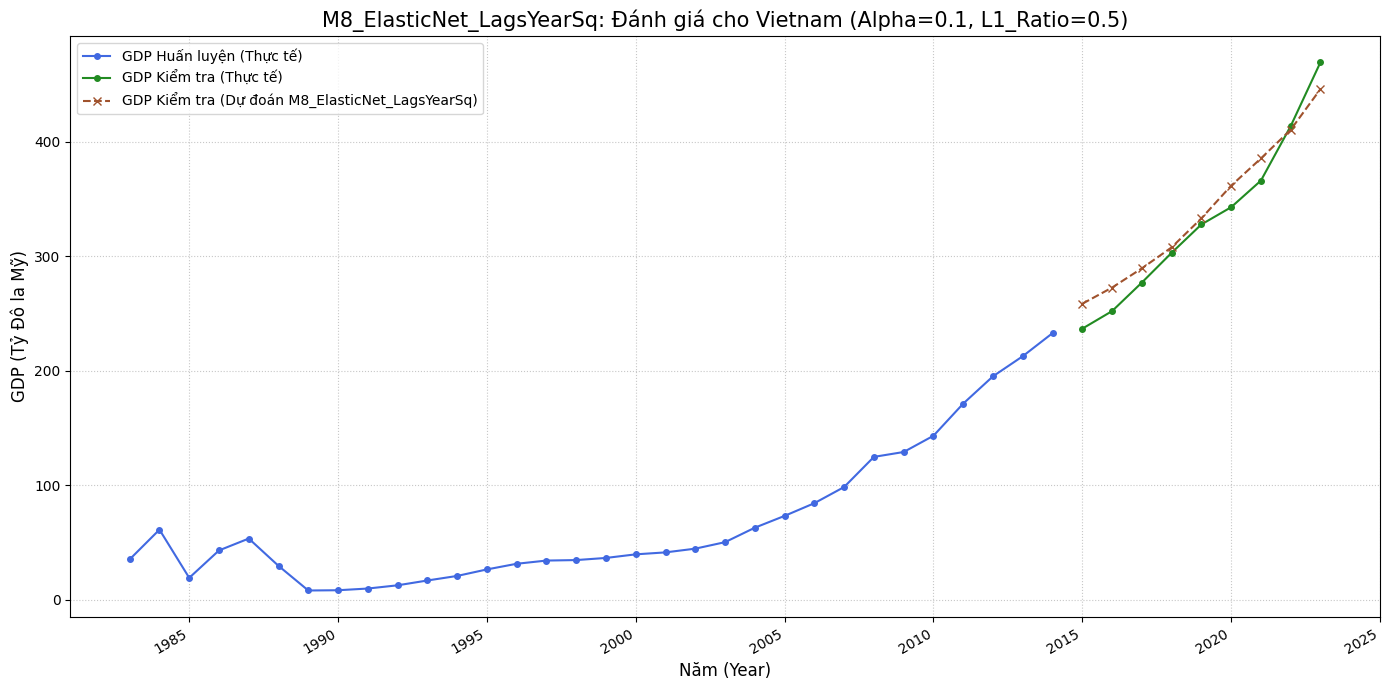

In [7]:
# --- CELL EN3.M8: {MODEL_ID_M8} - ĐÁNH GIÁ MÔ HÌNH ---

r2_en_m8, mae_en_m8, rmse_en_m8, mape_en_m8 = np.nan, np.nan, np.nan, np.nan
y_pred_test_m8 = None; y_pred_train_m8 = None

if 'model_en_m8' in locals() and model_en_m8 is not None and \
   'X_train_scaled_m8' in locals() and X_train_scaled_m8 is not None and \
   'X_test_scaled_m8' in locals() and X_test_scaled_m8 is not None and \
   'y_train_m8' in locals() and y_train_m8 is not None and \
   'y_test_m8' in locals() and y_test_m8 is not None and not y_test_m8.empty:
    
    y_pred_train_m8 = model_en_m8.predict(X_train_scaled_m8)
    y_pred_test_m8 = model_en_m8.predict(X_test_scaled_m8)

    print(f"\n--- {MODEL_ID_M8}: Đánh giá trên tập Huấn luyện ---")
    # ... (Code tính và in R2, MAE, RMSE, MAPE cho tập train) ...
    r2_train_m8 = r2_score(y_train_m8, y_pred_train_m8)
    mae_train_m8 = mean_absolute_error(y_train_m8, y_pred_train_m8)
    rmse_train_m8 = np.sqrt(mean_squared_error(y_train_m8, y_pred_train_m8))
    try:
        mape_train_m8 = np.mean(np.abs((y_train_m8 - y_pred_train_m8) / (y_train_m8 + 1e-9))) * 100
        print(f"R2: {r2_train_m8:.4f}, MAE: {mae_train_m8:.2f}, RMSE: {rmse_train_m8:.2f}, MAPE: {mape_train_m8:.2f}%")
    except Exception as e: print(f"R2: {r2_train_m8:.4f}, MAE: {mae_train_m8:.2f}, RMSE: {rmse_train_m8:.2f}, Lỗi MAPE: {e}")


    print(f"\n--- {MODEL_ID_M8}: Đánh giá trên tập Kiểm tra ---")
    r2_en_m8 = r2_score(y_test_m8, y_pred_test_m8)
    mae_en_m8 = mean_absolute_error(y_test_m8, y_pred_test_m8)
    rmse_en_m8 = np.sqrt(mean_squared_error(y_test_m8, y_pred_test_m8))
    
    y_true_m = y_test_m8.copy(); y_pred_m = pd.Series(y_pred_test_m8, index=y_true_m.index)
    zero_mask = (np.abs(y_true_m) < 1e-9)
    y_true_f = y_true_m[~zero_mask]; y_pred_f = y_pred_m[~zero_mask]
    if len(y_true_f) > 0: mape_en_m8 = np.mean(np.abs((y_true_f - y_pred_f) / y_true_f)) * 100
    else: mape_en_m8 = np.nan
            
    print(f"R-squared (Test): {r2_en_m8:.4f}")
    print(f"MAE (Test): {mae_en_m8:.2f}")
    print(f"RMSE (Test): {rmse_en_m8:.2f}")
    if not np.isnan(mape_en_m8): print(f"MAPE (Test): {mape_en_m8:.2f}% (Tính trên {len(y_true_f)} điểm)")
    else: print("MAPE (Test): Không thể tính.")

    plt.figure(figsize=(14, 7))
    if 'years_train_m8' in locals() and years_train_m8 is not None:
        plt.plot(years_train_m8, y_train_m8, label='GDP Huấn luyện (Thực tế)', color='royalblue', marker='o', markersize=4)
    if 'years_test_m8' in locals() and years_test_m8 is not None:
        plt.plot(years_test_m8, y_test_m8, label='GDP Kiểm tra (Thực tế)', color='forestgreen', marker='o', markersize=4)
        plt.plot(years_test_m8, y_pred_test_m8, label=f'GDP Kiểm tra (Dự đoán {MODEL_ID_M8})', color='sienna', marker='x', markersize=6, linestyle='--')
    plt.title(f'{MODEL_ID_M8}: Đánh giá cho {COUNTRY_M8} (Alpha={ALPHA_M8}, L1_Ratio={L1_RATIO_M8})', fontsize=15)
    plt.xlabel('Năm (Year)', fontsize=12); plt.ylabel('GDP (Tỷ Đô la Mỹ)', fontsize=12)
    plt.legend(fontsize=10); plt.grid(True, linestyle=':', alpha=0.7); plt.xticks(rotation=30, ha='right'); plt.tight_layout(); plt.show()
else:
    print(f"Mô hình {MODEL_ID_M8} chưa được huấn luyện hoặc không có dữ liệu test/train để đánh giá.")




--- M8_ElasticNet_LagsYearSq: PHÂN TÍCH PHẦN DƯ CHO VIETNAM ---


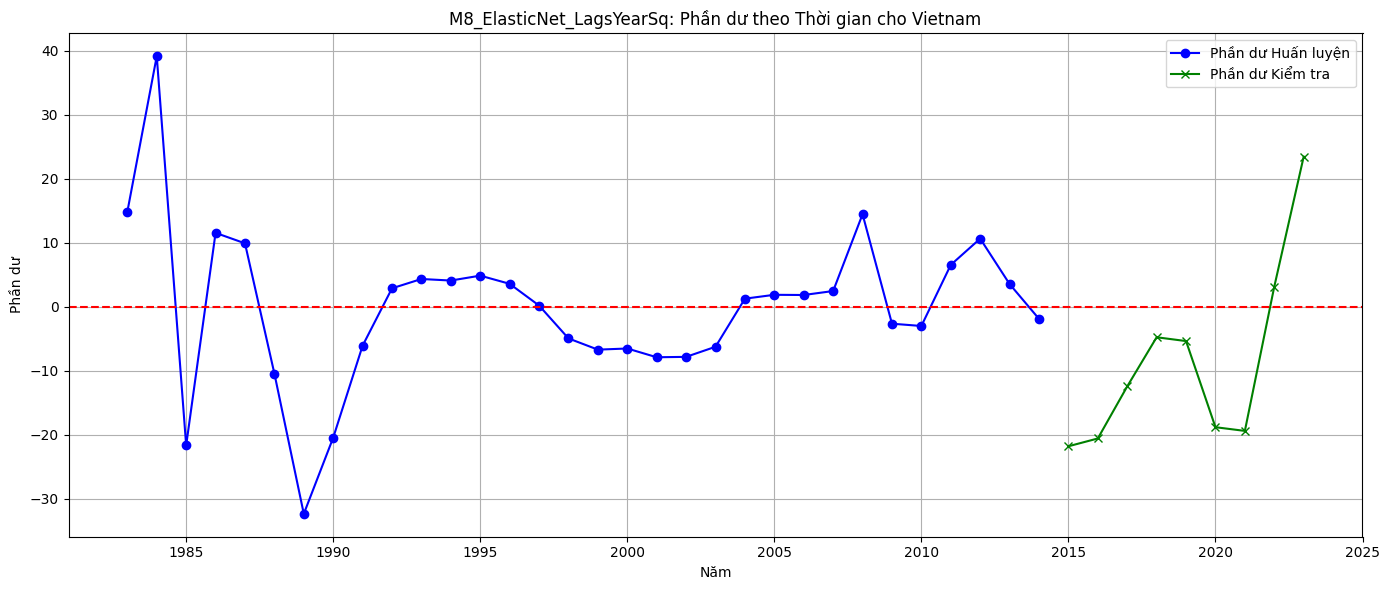

In [8]:
# --- CELL EN4.M8: {MODEL_ID_M8} - PHÂN TÍCH PHẦN DƯ ---
if 'model_en_m8' in locals() and model_en_m8 is not None and \
   'y_train_m8' in locals() and y_train_m8 is not None and 'y_pred_train_m8' in locals() and y_pred_train_m8 is not None and \
   'y_test_m8' in locals() and y_test_m8 is not None and 'y_pred_test_m8' in locals() and y_pred_test_m8 is not None:
    
    print(f"\n\n--- {MODEL_ID_M8}: PHÂN TÍCH PHẦN DƯ CHO {COUNTRY_M8.upper()} ---")
    residuals_train_m8 = y_train_m8 - y_pred_train_m8
    residuals_test_m8 = y_test_m8 - y_pred_test_m8

    # (Code vẽ các biểu đồ phần dư tương tự như các mô hình trước, thay hậu tố)
    # Ví dụ: Biểu đồ Phần dư theo Thời gian
    plt.figure(figsize=(14, 6))
    if 'years_train_m8' in locals() and years_train_m8 is not None:
        plt.plot(years_train_m8, residuals_train_m8, marker='o', linestyle='-', color='blue', label='Phần dư Huấn luyện')
    if 'years_test_m8' in locals() and years_test_m8 is not None and not residuals_test_m8.empty:
        plt.plot(years_test_m8, residuals_test_m8, marker='x', linestyle='-', color='green', label='Phần dư Kiểm tra')
    plt.axhline(y=0, color='r', linestyle='--'); plt.xlabel('Năm'); plt.ylabel('Phần dư')
    plt.title(f'{MODEL_ID_M8}: Phần dư theo Thời gian cho {COUNTRY_M8}'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
    # Thêm các biểu đồ khác: Residuals vs Predicted, Histogram, Q-Q
else:
    print(f"Mô hình {MODEL_ID_M8} chưa có đủ kết quả để phân tích phần dư.")